<a href="https://colab.research.google.com/github/TaylorKMac/CIFANETBYTAY/blob/main/CIFAR10_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb -qU #qU removes install logging output

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install torchviz -qU

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.9 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision grad-cam requests matplotlib -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 2.3.1 which is incompatible.


In [ ]:
!pip install captum -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.0 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 15.8 MB/s eta 0:00:00


In [ ]:
#all Import statements

#torch functions
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import RandomApply
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchviz import make_dot
from torch import tensor
from torchmetrics.classification import MulticlassConfusionMatrix

import multiprocessing
from PIL import Image

#for grad cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.image import show_factorization_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image
import requests
from io import BytesIO
import cv2
from IPython.display import Image as PyImage

#math stuff
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

#captum imports
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import seaborn as sn

import time
import wandb

In [ ]:
# Determine the number of CPU cores
num_cores = multiprocessing.cpu_count()
print(f'Number of CPU cores: {num_cores}')

# Determine the number of workers for DataLoader
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    num_workers = num_cores // num_gpus
else:
    num_workers = num_cores

print(f'Setting number of DataLoader workers to: {num_workers}')

#ASSIGNING DEVICE - use GPU if available and check.
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

print("Device:", device)

Number of CPU cores: 8
Setting number of DataLoader workers to: 8
CUDA is available. Using GPU.
Device: cuda


In [ ]:
# Initialize wandb with comprehensive configuration
wandb.init(project="CIFAR10_Class", config={
    "epochs": 50,
    "batch_size": 128,
    "dropout": 0.5,  # Add dropout rate to the configuration
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001,
        "momentum": 0.9,
        "weight_decay": 5e-4
    },
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "mode": "min",
        "factor": 0.1,
        "patience": 10,
        "min_lr": 1e-5
    },
    "criterion": {
        "type": "CrossEntropyLoss"
    },
    "dataset": {
        "name": "CIFAR10",
        "train_transforms": [
            "transforms.RandomCrop(32, padding=4)",
            "transforms.RandomHorizontalFlip()",
            "transforms.RandomRotation(15)",
            "transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)",
            "transforms.ToTensor()",
            "transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))"
        ],
        "test_transforms": [
            "transforms.ToTensor()",
            "transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))"
        ]
    }
})

config = wandb.config
#Api Key: b30e27d8326ad1a7558200779835eb0bd71310df

In [ ]:
# Data augmentation and normalization for training
# Dynamically construct transformations from the config
def construct_transforms(transform_list):
    transforms_compose = []
    for transform in transform_list:
        transforms_compose.append(eval(transform))
    return transforms.Compose(transforms_compose)

train_transform = construct_transforms(config['dataset']['train_transforms'])
test_transform = construct_transforms(config['dataset']['test_transforms'])

In [ ]:
# DOWNLOAD/INITILIZE DATASETS

# Dynamically get the dataset class from torchvision.datasets
DatasetClass = getattr(datasets, config['dataset']['name'])

# Initialize datasets
cifa_train = DatasetClass(root='./cifa10data', train=True, download=True, transform=train_transform)
cifa_test = DatasetClass(root='./cifa10data', train=False, download=True, transform=test_transform)

print(cifa_train)
print(cifa_test)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifa10data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifa10data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [ ]:
# LOADERS
# setting number of workers to cores available.
num_workers = multiprocessing.cpu_count() // torch.cuda.device_count() if torch.cuda.is_available() else multiprocessing.cpu_count()

train_loader = DataLoader(cifa_train, batch_size=config['batch_size'], shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(cifa_test, batch_size=config['batch_size'], shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


classes = ("airplane", "automobile", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

 ship | truck |   cat | truck | airplane | automobile | horse |  deer |  bird |  frog


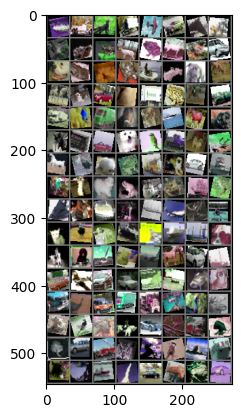

In [ ]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' | '.join('%5s' % classes[labels[j]] for j in range(10)))

In [ ]:
#an addaptive dropout class that modifies the dropout rate of the model as the loss decreases
class AdaptiveDropout(nn.Module):
  def __init__(self, initial_p = 0.5, loss_threshold = 0.5):
    super(AdaptiveDropout, self).__init__()
    self.p = initial_p
    self.loss_threshold = loss_threshold

  def forward(self, x, loss):
    if loss > self.loss_threshold:
      p = min(self.p + 0.2, 1.0)
    else:
      p = max(self.p - 0.2, 0.0)

    return func.dropout(x, p, self.training)

In [ ]:
# neural network with:
# 4 convolutional layers
# 4 batch normalization layers
# 4 pooling layers
# 6 rectified linear units
# 3 fully conected layers
# 2 dropout layers
# 1 flattening layer
class cifaNet(nn.Module):
    def __init__(self, initial_p = 0.5, loss_threshold = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, padding='same')
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_dropout = AdaptiveDropout(initial_p, loss_threshold)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, X, loss = None):
        X = self.pool(func.relu(self.bn1(self.conv1(X))))
        X = self.pool(func.relu(self.bn2(self.conv2(X))))
        X = self.pool(func.relu(self.bn3(self.conv3(X))))
        X = self.pool(func.relu(self.bn4(self.conv4(X))))

        X = X.view(X.size(0), -1)

        if loss is not None:
          X = self.adaptive_dropout(func.relu(self.fc1(X)), loss)
          X = self.adaptive_dropout(func.relu(self.fc2(X)), loss)
        else:
          X = func.dropout(func.relu(self.fc1(X)), p = 0.5, training = self.training)
          X = func.dropout(func.relu(self.fc2(X)), p = 0.5, training = self.training)
        X = self.fc3(X)
        return func.log_softmax(X, dim = 1)

In [ ]:
# INITIALIZE MODEL
model = cifaNet().to(device)
print(model)
print(f'\nNumber of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
print(f'---\nmodel initilized')

cifaNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_dropout): AdaptiveDropout()
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

Number of paramet

In [ ]:
model = model.to(device)

In [ ]:
# OPTIMIZER/ LEARNING RATE SCHEDULER / CRITERION

# Dynamically set optimizer
optimizer_class = getattr(optim, config['optimizer']['type'])
if config['optimizer']['type'] == 'SGD':
    optimizer = optimizer_class(model.parameters(), lr=config['optimizer']['learning_rate'], momentum=config['optimizer']['momentum'], weight_decay=config['optimizer']['weight_decay'])
else:
    optimizer = optimizer_class(model.parameters(), lr=config['optimizer']['learning_rate'], weight_decay=config['optimizer']['weight_decay'])


# Dynamically set learning rate scheduler
scheduler_class = getattr(optim.lr_scheduler, config['scheduler']['type'])
scheduler = scheduler_class(optimizer, mode=config['scheduler']['mode'], factor=config['scheduler']['factor'], patience=config['scheduler']['patience'], min_lr =config['scheduler']['min_lr'] )

# Dynamically set criterion
criterion_class = getattr(nn, config['criterion']['type'])
criterion = criterion_class()

# Print types of optimizer, scheduler, and criterion
print(f'---\ninitialized...\nOptimizer: {type(optimizer).__name__}\nScheduler: {type(scheduler).__name__}\nCriterion: {type(criterion).__name__}')

---
initialized...
Optimizer: Adam
Scheduler: ReduceLROnPlateau
Criterion: CrossEntropyLoss


In [ ]:
#load best model from wandb

model.load_state_dict(torch.load(best_model_filename))

<All keys matched successfully>

In [ ]:
#training and accuracy testing
start_time = time.time()

epochs = config['epochs']
best_accuracy = 0.0
best_epoch = 0
best_model_filename = None

[1,    20] loss: 0.506
[1,    40] loss: 0.526
[1,    60] loss: 0.561
[1,    80] loss: 0.540
[1,   100] loss: 0.557
[1,   120] loss: 0.555
[1,   140] loss: 0.547
[1,   160] loss: 0.555
[1,   180] loss: 0.550
[1,   200] loss: 0.600
[1,   220] loss: 0.596
[1,   240] loss: 0.573
[1,   260] loss: 0.533
[1,   280] loss: 0.541
[1,   300] loss: 0.536
[1,   320] loss: 0.589
[1,   340] loss: 0.583
[1,   360] loss: 0.582
[1,   380] loss: 0.590
Epoch 1/50, Loss: 0.0160, Accuracy: 83.05%
[2,    20] loss: 0.560
[2,    40] loss: 0.530
[2,    60] loss: 0.599
[2,    80] loss: 0.601
[2,   100] loss: 0.567
[2,   120] loss: 0.587
[2,   140] loss: 0.601
[2,   160] loss: 0.600
[2,   180] loss: 0.569
[2,   200] loss: 0.571
[2,   220] loss: 0.586
[2,   240] loss: 0.597
[2,   260] loss: 0.599
[2,   280] loss: 0.578
[2,   300] loss: 0.601
[2,   320] loss: 0.565
[2,   340] loss: 0.551
[2,   360] loss: 0.553
[2,   380] loss: 0.565
Epoch 2/50, Loss: 0.0162, Accuracy: 83.94%
[3,    20] loss: 0.568
[3,    40] loss: 

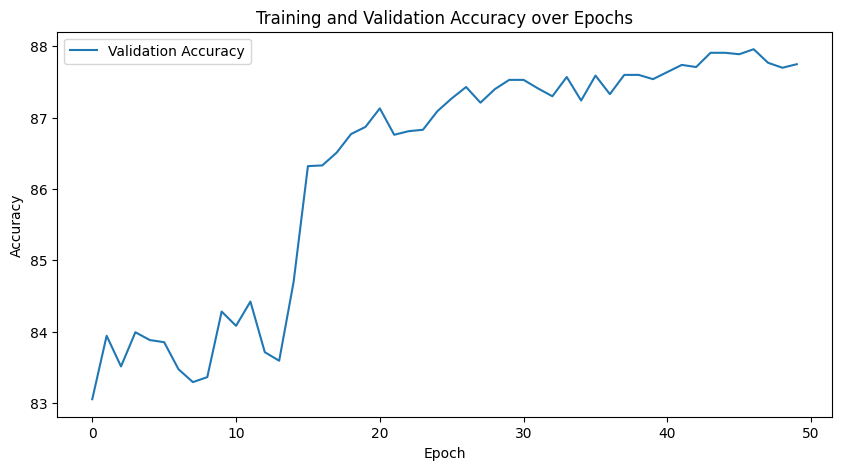

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,▇▇▆▇▇▇▇▇▆▇█▇▄▅▄▄▄▄▄▂▃▃▃▃▃▂▃▂▂▃▂▂▂▂▁▂▂▂▂▁
val_accuracy,▁▂▂▂▂▂▁▁▂▃▂▂▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,▇▅▆▃█▃▅▄▅▅▇▄▄▃▄▄▂▃▆▂▄▃▄▃▄▃▂▄▁▄▂▄▂▃▁▃▄▂▂▂
epoch,50
train_loss,0.00928
val_accuracy,87.75
val_loss,0.32053


In [ ]:

# Lists to store loss and accuracy for plotting
accuracies = []


#For loop of Epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
          model(inputs, loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0


     # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

    scheduler.step(test_loss)

    # Save the model if it has the best accuracy so far
    if accuracy > best_accuracy:
        new_model_filename = f'best_model_epoch_{epoch}_acc_{accuracy:.2f}.pth'
        best_accuracy = accuracy
        best_epoch = epoch +1
        best_model_filename = new_model_filename
        torch.save(model.state_dict(), best_model_filename)
        print(f'Model saved as {best_model_filename}!')
        wandb.save(best_model_filename)
    wandb.log({
            "epoch": epoch + 1,
            "train_loss": running_loss/len(train_loader),
            "val_loss": test_loss,
            "val_accuracy": accuracy,
        })


current_time = time.time()
total = current_time - start_time

print(f'training took: {total/60} minutes')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Finish the wandb run
wandb.finish()

In [ ]:
model.load_state_dict(torch.load(best_model_filename))

<All keys matched successfully>

GroundTruth:  cat   | ship  | ship  | airplane
Predicted:  cat   | ship  | automobile | airplane


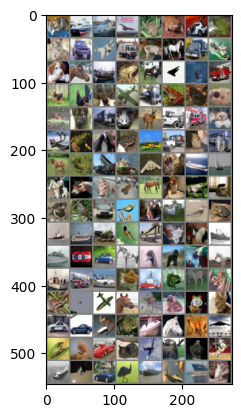

In [ ]:
# get some random test images
DI = iter(test_loader)
T_images, T_labels = next(DI)

# print images
imshow(make_grid(T_images))
print('GroundTruth: ', ' | '.join(f'{classes[T_labels[j]]:5s}' for j in range(4)))


outputs = model(T_images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' | '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Final Accuracy of the network on the 10000 test images: 87.96 %


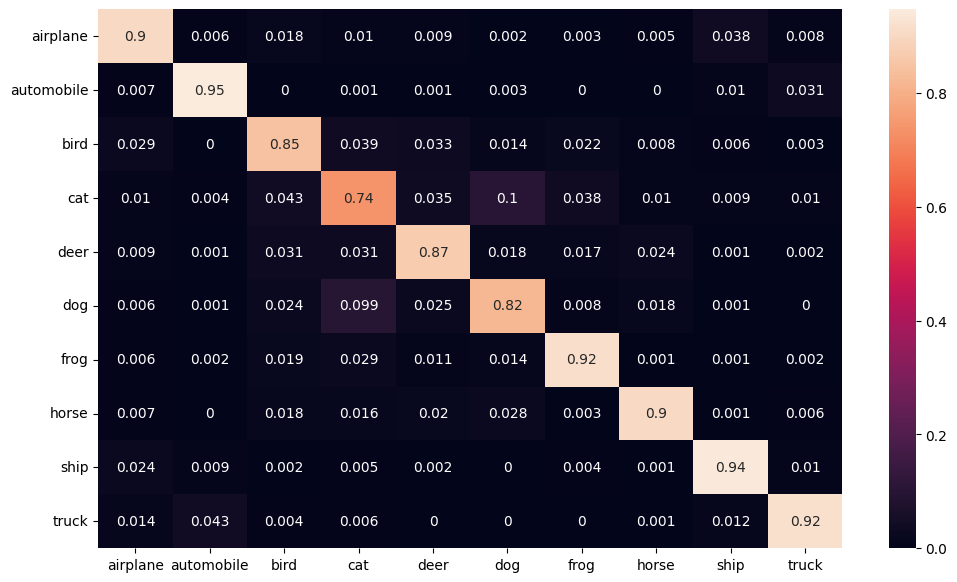

In [ ]:
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
#build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure (figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')

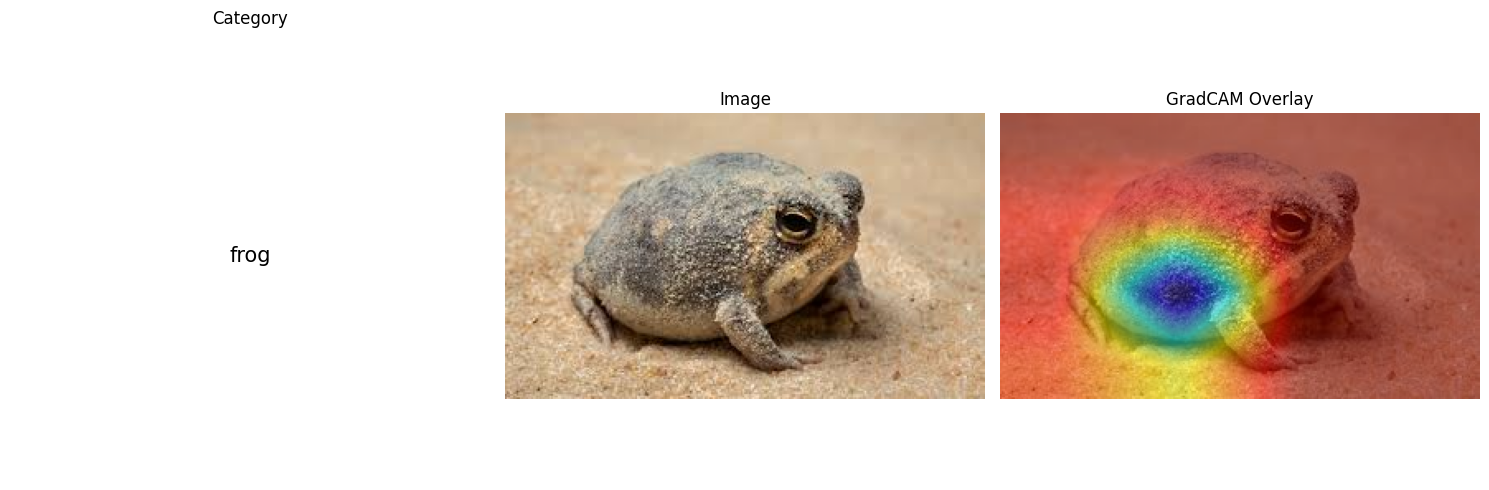

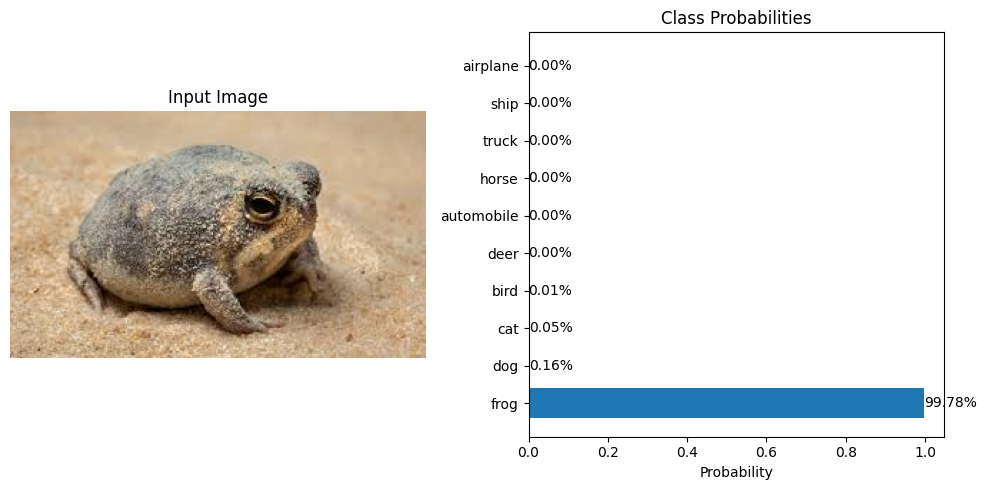

In [ ]:
# Function to preprocess the input image from URL
def preprocess_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor

# Function to overlay CAM on image
def show_cam_on_image(img, mask, use_rgb=False, colormap=cv2.COLORMAP_JET):
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))  # Resize mask to match image size
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Function to generate Grad-CAM and visualize it
def generate_grad_cam(url, model, target_layers, classes, device):
    original_image, input_tensor = preprocess_image_from_url(url)
    cam = GradCAM(model=model.to(device), target_layers=target_layers)

    # Get the model output and predicted class
    model.eval()
    input_tensor = input_tensor.to(device)
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()
    predicted_class_name = classes[predicted_class]

    # Generate CAM
    targets = [ClassifierOutputTarget(predicted_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    rgb_image = np.array(original_image) / 255.0
    cam_image = show_cam_on_image(rgb_image, grayscale_cam)

    # Create a table layout with category, original image, and Grad-CAM
    fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
    # Plot the category name
    axarr[0].axis('off')
    axarr[0].text(0.5, 0.5, predicted_class_name, horizontalalignment='center', verticalalignment='center', fontsize=15)
    axarr[0].set_title("Category")

    # Plot the original image
    axarr[1].imshow(original_image)
    axarr[1].axis('off')
    axarr[1].set_title("Image")

    # Overlay Grad-CAM heatmap on the original image
    axarr[2].imshow(cam_image)
    axarr[2].axis('off')
    axarr[2].set_title("GradCAM Overlay")
    axarr[2].imshow(cam_image, alpha=0.2)  # Overlay heatmap with transparency

    plt.tight_layout()
    plt.show()

# Get model output
def get_model_output(model, img_tensor, device):
    model.eval()
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
    return outputs

# Convert logits to probabilities
def get_probabilities(outputs):
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities

# Display probabilities for each class along with the image
def display_image_and_probabilities(img, probabilities, classes):
    probs, indices = probabilities.topk(len(classes))

    # Display the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")

    # Display the probabilities
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(classes))
    probs = [probs[0][i].item() for i in range(len(classes))]
    class_labels = [classes[indices[0][i]] for i in range(len(classes))]
    plt.barh(y_pos, probs, align='center')
    plt.yticks(y_pos, class_labels)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')

    for i in range(len(classes)):
        plt.text(probs[i], y_pos[i], f"{probs[i]*100:.2f}%", va='center')

    plt.tight_layout()
    plt.show()


# Example usage
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRW43z5Akg5WIcbb46WszuPDZ0rGSnvEKxWLQ&s"  # Replace with your image URL
generate_grad_cam(image_url, model, [model.conv4], classes, device)
img, img_tensor = preprocess_image_from_url(image_url)
outputs = get_model_output(model, img_tensor, device)
probabilities = get_probabilities(outputs)
display_image_and_probabilities(img, probabilities, classes)

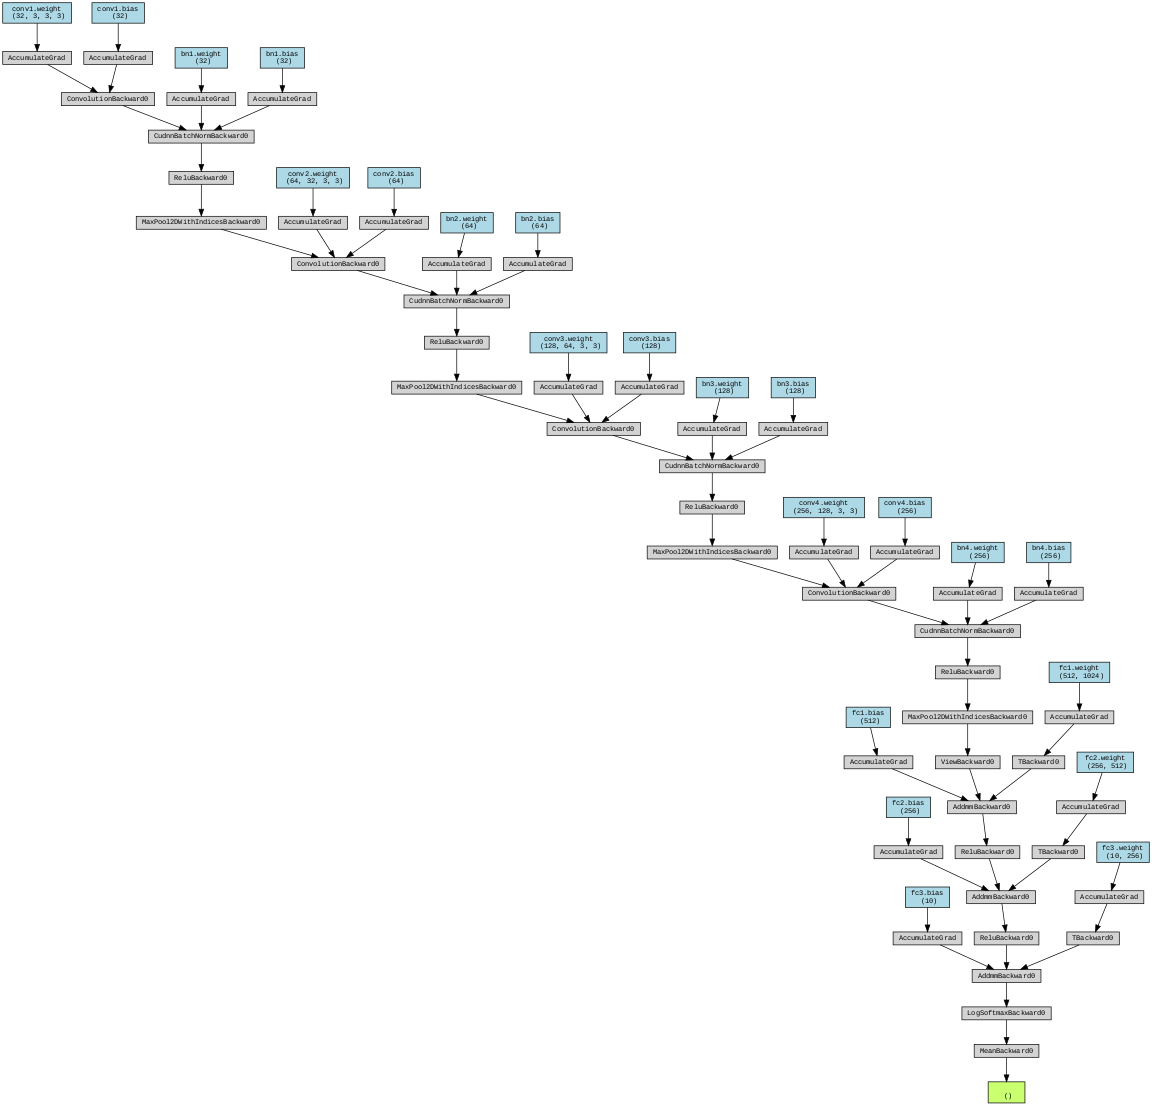

In [ ]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Forward pass through the model to get the output tensor
outputs = model(images)

# Generate the computation graph
dot = make_dot(outputs.mean(), params=dict(model.named_parameters()))

# Render and save the graph to a file with a larger resolution
dot.format = 'png'
dot.attr(size="12,12")
dot.render("model_visualization")

# Display the graph
PyImage(filename="model_visualization.png")


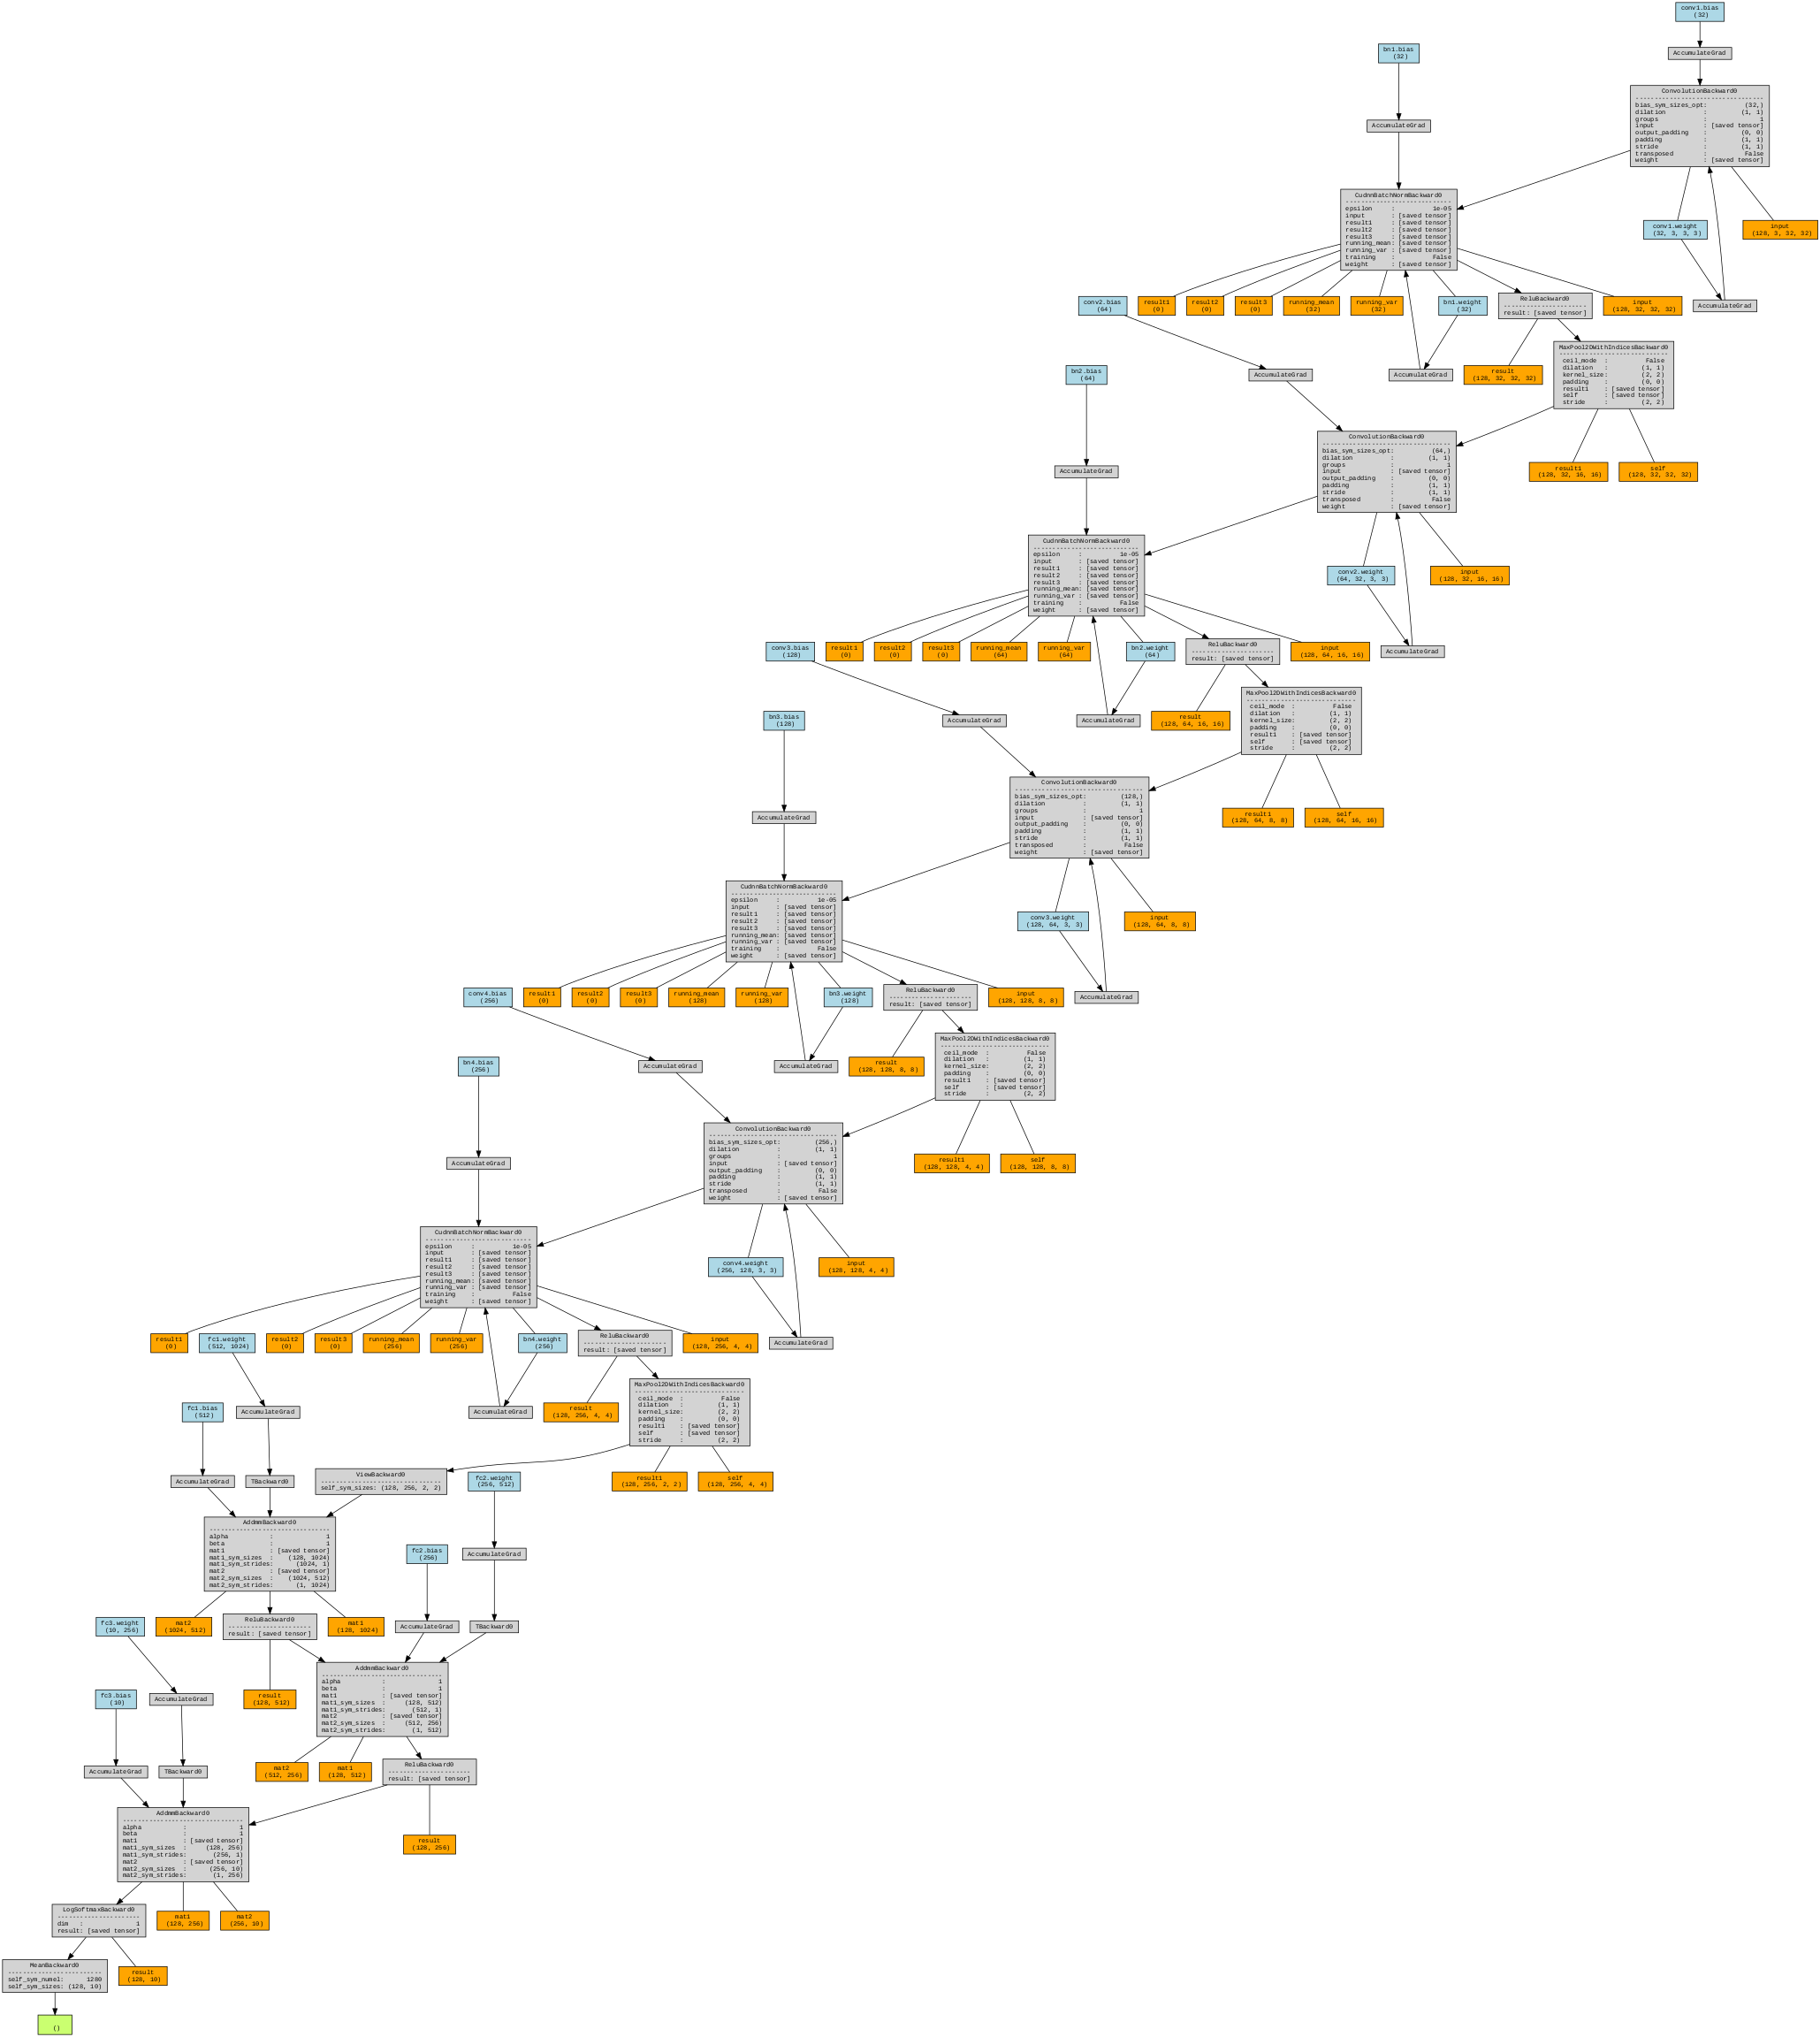

In [ ]:
dot = make_dot(outputs.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


# Render and save the graph to a file with a larger resolution
dot.format = 'png'
dot.attr(size="24,24")
dot.render("model_visualization")

# Display the graph
PyImage(filename="model_visualization.png")

GroundTruth:  cat   | ship  | ship  | airplane
Predicted:  cat   | ship  | automobile | airplane


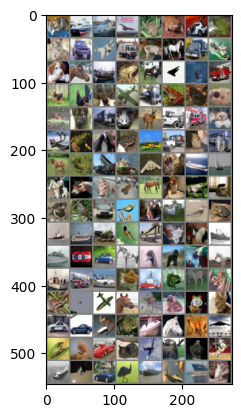

In [ ]:
# get some random test images
DI = iter(test_loader)
T_images, T_labels = next(DI)

# print images
imshow(make_grid(T_images))
print('GroundTruth: ', ' | '.join(f'{classes[T_labels[j]]:5s}' for j in range(4)))

outputs = model(T_images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' | '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
ind = 50

input = T_images[ind].unsqueeze(0)
input.requires_grad = True

In [ ]:
model.eval()

cifaNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_dropout): AdaptiveDropout()
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )

    return tensor_attributions

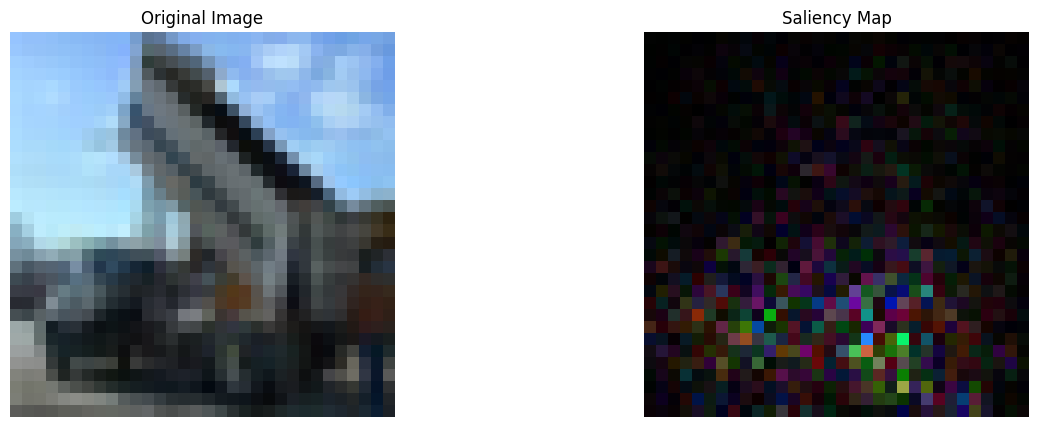

In [ ]:
# Ensure the index is within the bounds of the batch size
batch_size = outputs.size(0)
ind = min(ind, batch_size - 1)  # Adjust 'ind' to be within the range

# Prepare the input tensor
input = T_images[ind].unsqueeze(0).to(device)
input.requires_grad = True

model.eval()
saliency = Saliency(model)
grads = saliency.attribute(input, target=T_labels[ind].item())
grads = np.transpose(grads.squeeze().detach().cpu().numpy(), (1, 2, 0))

# Normalize the gradients to the range [0, 1]
grads = (grads - grads.min()) / (grads.max() - grads.min())

# Plot the original image and the saliency map
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Original image (move back to CPU and unnormalize for plotting)
original_img = input.squeeze().detach().cpu().numpy()
original_img = np.transpose(original_img, (1, 2, 0)) / 2 + 0.5

ax[0].imshow(original_img)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Saliency map
ax[1].imshow(grads)
ax[1].axis('off')
ax[1].set_title('Saliency Map')

plt.show()

In [ ]:
# Integrated Gradients
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0285], device='cuda:0', dtype=torch.float64)


In [ ]:
# NoiseTunnel + Integrated Gradients
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

batch_size: 128, num_classes: 10
predicted.shape: torch.Size([128])
outputs.shape: torch.Size([128, 10])
images.shape: torch.Size([128, 3, 32, 32])
grads.shape: (32, 32, 3)
attr_ig.shape: (32, 32, 3)
attr_ig_nt.shape: (32, 32, 3)
Original Image
Predicted: truck  Probability: 0.9999470710754395


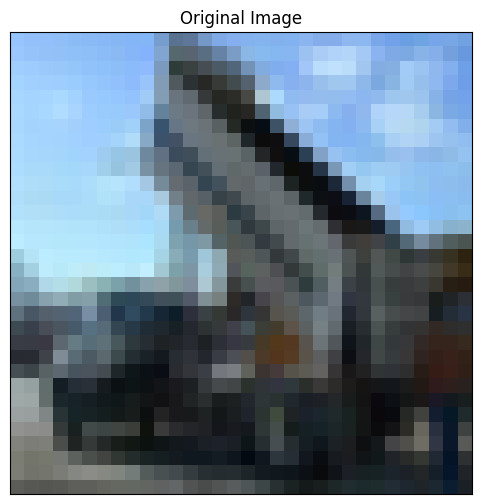

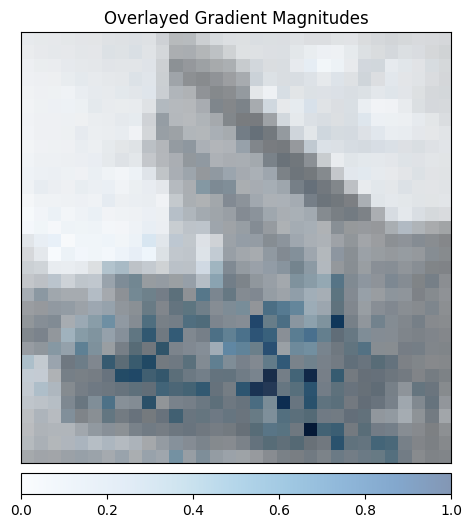

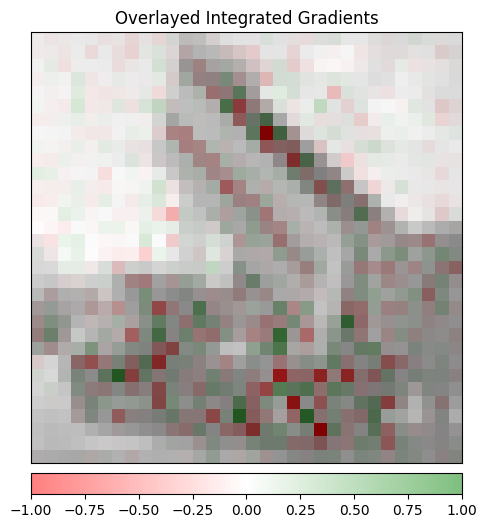

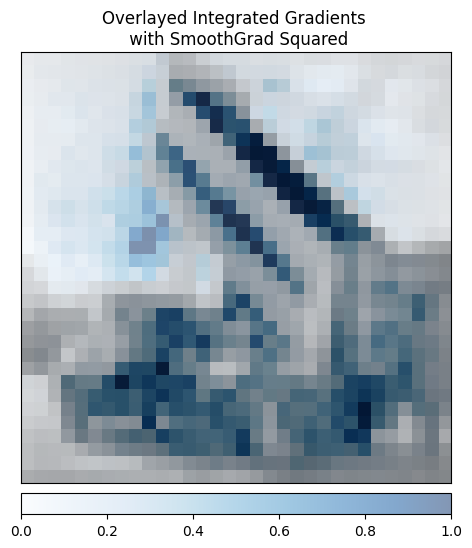

In [ ]:

# Print shapes of tensors to debug
print(f'batch_size: {outputs.size(0)}, num_classes: {outputs.size(1)}')
print(f'predicted.shape: {predicted.shape}')
print(f'outputs.shape: {outputs.shape}')
print(f'images.shape: {images.shape}')
print(f'grads.shape: {grads.shape}')
print(f'attr_ig.shape: {attr_ig.shape}')
print(f'attr_ig_nt.shape: {attr_ig_nt.shape}')

# Print prediction and probability
print('Original Image')
print('Predicted:', classes[predicted[ind]], ' Probability:', torch.max(func.softmax(outputs, 1)[ind]).item())

# Prepare the original image for visualization
original_image = np.transpose((T_images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

# Visualize the original image
_ = viz.visualize_image_attr(None, original_image, method="original_image", title="Original Image")

# Visualize the saliency map
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                             show_colorbar=True, title="Overlayed Gradient Magnitudes")

# Visualize the integrated gradients
_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map", sign="all",
                             show_colorbar=True, title="Overlayed Integrated Gradients")

# Visualize the integrated gradients with noise tunnel
_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

In [ ]:
def get_image_from_url(url):
    """A function that gets a URL of an image,
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    rgb_img_float = np.float32(img) / 255
    # Removed the call to preprocess_image as it is likely already a tensor
    input_tensor = transform(img).unsqueeze(0) # Pass the PIL Image directly
    return img, rgb_img_float, input_tensor

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the expected input size for the model
input_size = 32

# Function to process and visualize the image
def visualize_image(model, image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),  # Ensure the image is resized to the input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)

    # Process the output and convert to numpy array for visualization
    output_np = output.squeeze().cpu().numpy()
    output_image = (output_np - output_np.min()) / (output_np.max() - output_np.min())
    output_image = (output_image * 255).astype(np.uint8)
    return output_image

# Visualize the images
display(Image.fromarray(visualize_image(model, "https://th-thumbnailer.cdn-si-edu.com/ii_ZQzqzZgBKT6z9DVNhfPhZe5g=/fit-in/1600x0/filters:focal(1061x707:1062x708)/https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer_public/55/95/55958815-3a8a-4032-ac7a-ff8c8ec8898a/gettyimages-1067956982.jpg")))